[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](http://colab.research.google.com/github/ai2es/WAF_ML_Tutorial_Part2/blob/main/colab_notebooks/Notebook03_Retrain_Traditional_ML.ipynb)

# Notebook 03: Retrain traditional ML 

Authors: Randy J. Chase, David R. Harrison, Gary M. Lackmann, and Amy McGovern<br>
Institution: [AI2ES](https://www.ai2es.org)<br>
Associated paper: [A Machine Learning Tutorial for Operational Meteorology, Part II: Neural Networks and Deep Learning](https://arxiv.org/abs/2211.00147)<br>
Original Github: [WAF_ML_Tutorial_Part1](https://github.com/ai2es/WAF_ML_Tutorial_Part2)

If you use this code or data in your work, please cite the paper: 

Chase, R. J., Harrison, D. R., Lackmann, G. M., & McGovern, A. (2023). A Machine Learning Tutorial for Operational Meteorology. Part II: Neural Networks and Deep Learning, 	arXiv:2211.00147.


### Primary Goal: Re-train the traditional methods (e.g., random forest). 

#### Background

It is always good to compare your machine learning models to a baseline. In this tutorial we are jumping into neural networks which can be quite complicated.
Thus, to serve as a reference point, we will compare the neural network results to the more traditional machine learning methods that were covered in [Part1](https://github.com/ai2es/WAF_ML_Tutorial_Part1). 
Remember that in order to make this tutorial viable, we created the sub-SEVIR dataset as described in the [last notebook](https://github.com/ai2es/WAF_ML_Tutorial_Part2/blob/main/jupyter_notebooks/Notebook2_Explore_sub_sevir.ipynb).  However, sub-SEVIR contains less information content than what was used to train the machine learning models in Part 1. 

To account for this, I have already extracted the percentile information used in Part 1 from the sub-SEVIR dataset and placed it in the repository. This notebook will be a good refresher of how to fit ML models using sklearn. 

#### Step 1: Install some things and grab the data

Note: downloading the data can take up to 15-20 mins depending on the server speed. Please be patient


In [ ]:
#@title Install and unpack files [this will take some time]

print('installing dependancies')
!pip -q install zenodo-get
!pip -q install zarr 
print('grabbing sub-sevir')
!zenodo_get 7011372
print('unpacking sub-sevir')
!tar -xf sub-sevir.tar.gz
!tar -xf sub-sevir/sub-sevir-train.tar.gz -C sub-sevir/
!tar -xf sub-sevir/sub-sevir-val.tar.gz -C sub-sevir/
!tar -xf sub-sevir/sub-sevir-test.tar.gz -C sub-sevir/
print('grabbing the Github repo')
!git clone https://github.com/ai2es/WAF_ML_Tutorial_Part2.git
print('done')

In [17]:
import pandas as pd 
import numpy as np 
import tqdm 
import matplotlib
import matplotlib.pyplot as plt 

#plot parameters that I personally like, feel free to make these your own.
matplotlib.rcParams['axes.facecolor'] = [0.9,0.9,0.9]
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['axes.titlesize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['legend.fontsize'] = 12
matplotlib.rcParams['legend.facecolor'] = 'w'
matplotlib.rcParams['savefig.transparent'] = False
%config InlineBackend.figure_format = 'retina'


#### Step 2: Load in the pre-made data 

Now go ahead and load in the pre-made percentiles from this repository.

In [18]:
#load training 
df_t = pd.read_csv('/content/WAF_ML_Tutorial_Part2/datasets/sub-sevir-engineered/lowres_features_train.csv')
#load validation set
df_v = pd.read_csv('/content/WAF_ML_Tutorial_Part2/datasets/sub-sevir-engineered/lowres_features_val.csv')

#print out df_t, items at the bottom of the cell get printed
df_t

,q000_ir,q001_ir,q010_ir,q025_ir,q050_ir,q075_ir,q090_ir,q099_ir,q100_ir,q000_wv,...,q001_vl,q010_vl,q025_vl,q050_vl,q075_vl,q090_vl,q099_vl,q100_vl,label_class,label_reg
0,-2.196238,-1.949695,-1.791281,-1.528253,-1.010820,0.495947,1.456004,1.500297,1.509985,-3.016850,...,-0.206396,-0.206396,-0.206396,-0.206396,0.029683,0.789612,7.986002,24.557011,1.0,600.0
1,-2.097033,-1.949780,-1.785856,-1.546079,-0.995319,0.398583,1.445153,1.498747,1.511147,-2.861186,...,-0.206396,-0.206396,-0.206396,-0.206396,0.023692,0.789612,6.997860,23.928528,1.0,555.0
2,-2.191200,-1.950458,-1.779152,-1.547726,-1.009851,0.329993,1.425157,1.496798,1.508822,-3.032837,...,-0.206396,-0.206396,-0.206396,-0.206396,0.017852,0.834176,7.185461,23.316002,1.0,486.0
3,-2.069906,-1.953159,-1.768301,-1.545692,-0.995707,0.253361,1.396985,1.494484,1.504172,-2.798920,...,-0.206396,-0.206396,-0.206396,-0.206396,0.012161,0.807767,6.642037,24.557011,1.0,356.0
4,-2.038905,-1.955155,-1.766751,-1.539879,-0.963930,0.217225,1.364627,1.492547,1.506885,-2.714777,...,-0.206396,-0.206396,-0.206396,-0.206396,0.017852,0.861273,8.199336,22.719021,1.0,416.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,-1.797481,-1.756005,-1.633949,-1.518081,-1.326841,-0.951142,-0.594974,-0.133138,0.101357,-2.148497,...,-0.183930,-0.144616,-0.127766,-0.099991,-0.045853,0.035831,0.178063,0.291140,0.0,0.0
59996,-1.791669,-1.759493,-1.635886,-1.520793,-1.335366,-0.955986,-0.572343,-0.065156,0.080043,-2.162801,...,-0.183930,-0.144616,-0.127766,-0.097220,-0.045853,0.042138,0.178356,0.389232,0.0,0.0
59997,-1.805232,-1.764918,-1.637049,-1.519437,-1.333816,-0.968774,-0.581837,-0.085438,0.117633,-2.181313,...,-0.206396,-0.144616,-0.127766,-0.097220,-0.045853,0.029683,0.188375,0.345023,0.0,0.0
59998,-1.796706,-1.757168,-1.637979,-1.526606,-1.336722,-0.984953,-0.574862,-0.046849,0.077331,-2.172899,...,-0.206396,-0.144616,-0.127766,-0.094377,-0.041672,0.035831,0.209202,0.404742,0.0,0.0


I find it useful to always look at the data you load in. So here we have a dataframe that contains all of our percentiles ```(q_***_var)```, where the stars are the percentile (000 means min) and the ```_var``` is the variable (e.g., ir is infrared). Then the far right columns contain the labels, one for classification and one for regression. 

I'm a visual learner, so lets look at the distribution of the minimum brightness temperature of IR (```q000_ir```)

(array([1.000e+00, 0.000e+00, 4.000e+00, 1.200e+01, 3.000e+01, 6.700e+01,
        8.000e+01, 1.830e+02, 2.790e+02, 3.960e+02, 5.210e+02, 6.600e+02,
        8.260e+02, 9.960e+02, 1.226e+03, 1.454e+03, 1.466e+03, 1.554e+03,
        1.577e+03, 1.660e+03, 1.630e+03, 1.730e+03, 1.652e+03, 1.706e+03,
        1.729e+03, 1.701e+03, 1.811e+03, 1.884e+03, 1.980e+03, 1.879e+03,
        1.883e+03, 1.901e+03, 1.797e+03, 1.959e+03, 1.605e+03, 1.415e+03,
        1.385e+03, 1.311e+03, 1.227e+03, 1.023e+03, 9.770e+02, 7.550e+02,
        6.490e+02, 6.310e+02, 6.890e+02, 5.730e+02, 5.630e+02, 5.430e+02,
        5.090e+02, 4.810e+02, 3.840e+02, 4.430e+02, 4.090e+02, 3.830e+02,
        3.310e+02, 3.040e+02, 2.500e+02, 2.000e+02, 2.550e+02, 2.310e+02,
        2.220e+02, 1.870e+02, 2.050e+02, 1.590e+02, 1.220e+02, 1.790e+02,
        1.460e+02, 1.510e+02, 1.560e+02, 1.570e+02, 1.340e+02, 1.390e+02,
        1.020e+02, 1.020e+02, 9.500e+01, 1.200e+02, 1.150e+02, 1.560e+02,
        1.390e+02, 9.700e+01, 1.180e+0

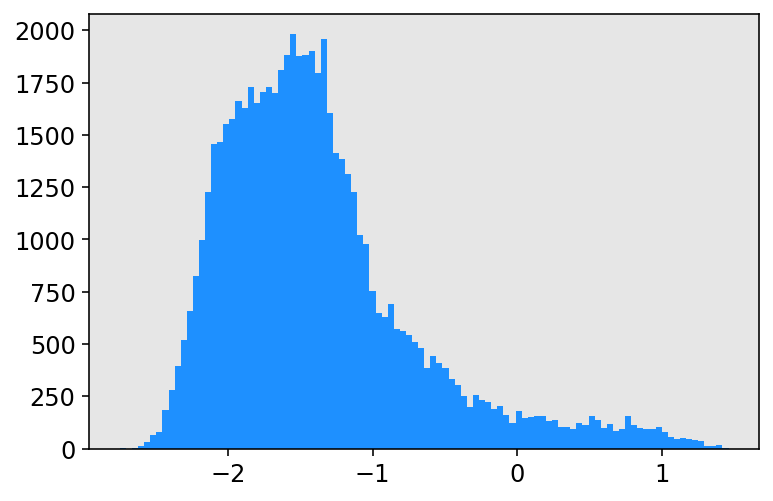

In [19]:
plt.hist(df_t.q000_ir,bins=100,color='dodgerblue')

Notice the x-axis here doesn't appear to be in degC or K. That is because the data is already normalized for you. Remember from the discussion in Part 1 that it is always good to normalize your data so that you don't unintentionally bias your ML model to a specific feature due to its natural magnitude. If you wish to scale the data back into its original units, please read the ```README.md``` in the same directory as the data. 

We do have to do one step to make the data ready for ML. We need to split the *features* (inputs) from the *labels* (outputs). Column 36 is the classification label, so let's slice the matrix with all the entries to the left of column 36 as the features (X) and column 36 as the label (y).


In [20]:
X_t = df_t.to_numpy()[:,:36]
y_t = df_t.to_numpy()[:,36]
X_v = df_v.to_numpy()[:,:36]
y_v = df_v.to_numpy()[:,36]

#### Step 3: Train some classification models! 

In the paper, we trained all the same ML models as Part 1. This included: logistic regression, naive bayes, decision trees, random forests, gradient boosted trees and support vector machines. 

Recall from the Part 1 notebooks that these models are all easy to train! Here we leverage ```sklearn``` and their uniform syntax to train all of the models at the same time. First we need to prepare our models for training:

In [21]:
#load ML code from sklearn
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB

#initialize models in a list that we can loop over 
model_list = [LogisticRegression(),GaussianNB(),DecisionTreeClassifier(),RandomForestClassifier(),GradientBoostingClassifier(),LinearSVC(dual=False)]

print(model_list)

[LogisticRegression(), GaussianNB(), DecisionTreeClassifier(), RandomForestClassifier(), GradientBoostingClassifier(), LinearSVC(dual=False)]


Okay, now we are ready to loop over this list of models and train them: 

In [22]:
#Import a progress bar so we know how long it is taking
import tqdm 

#loop over models and train with the same training data
for model in tqdm.tqdm(model_list):
    model.fit(X_t,y_t)

  0%|                                                     | 0/6 [00:00<?, ?it/s]/Users/randyjc2/miniconda3/envs/waf_tutorial_part2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
100%|█████████████████████████████████████████████| 6/6 [01:01<00:00, 10.18s/it]


Okay, models are trained ... now what? 

#### Step 4: Evaluate models

I hope you guessed that the next step is to evaluate the models. To do this, we will go back to the ROC curve and the Performance diagrams! We will use the exact same code from part one. 

First up, the performance diagram

LgR accuracy: 89.0%
LgR CSI: 0.81
NB accuracy: 85.0%
NB CSI: 0.76
DT accuracy: 86.0%
DT CSI: 0.77
RF accuracy: 90.0%
RF CSI: 0.83
GBT accuracy: 90.0%
GBT CSI: 0.84
SVM accuracy: 89.0%
SVM CSI: 0.81


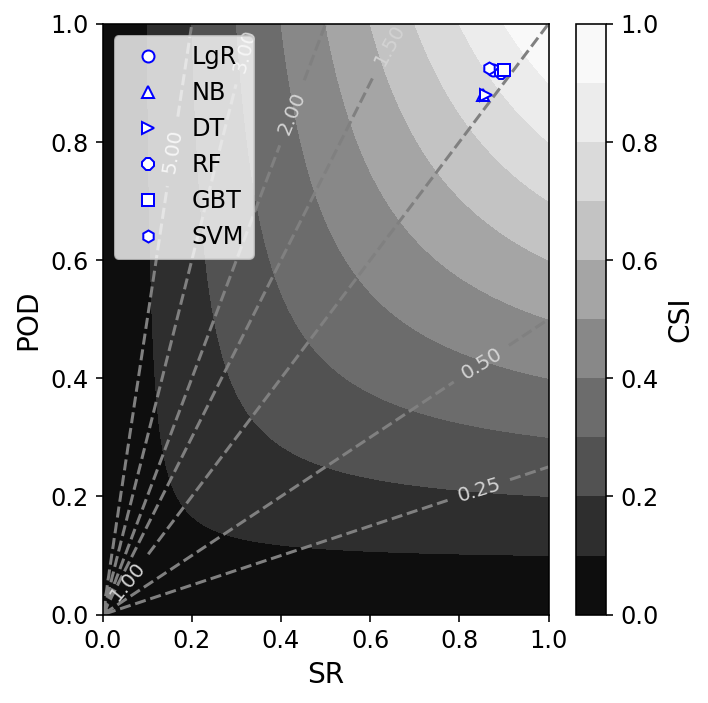

In [24]:
#import some helper functions from our other directory.
import sys
sys.path.insert(1, '/content/WAF_ML_Tutorial_Part2/scripts/')

#load contingency_table func
from gewitter_functions import get_contingency_table,make_performance_diagram_axis,get_acc,get_pod,get_sr,csi_from_sr_and_pod

#make axis to plot on 
ax = make_performance_diagram_axis()

#make list of colors so each method shows up as a different color
colors=['b','b','b','b','b','b']
legend_labels = ['LgR','NB','DT','RF','GBT','SVM']
#list of different marker types, check the documentation here for the full list: https://matplotlib.org/stable/api/markers_api.html 
markers = ['o','^','>','8','s','h']

#loop over all trained models 
for idx,model in enumerate(model_list):
    #get predictions 
    yhat = model.predict(X_v)
    #the contingency table calculator expects y_true,y_pred
    cont_table = get_contingency_table(y_v,yhat)
    
    #get metrics
    accuracy = get_acc(cont_table)
    pod = get_pod(cont_table)
    sr = get_sr(cont_table)
    csi = csi_from_sr_and_pod(sr,pod)
    
    #plot the marker 
    ax.plot(sr,pod,markers[idx],color=colors[idx],markerfacecolor='w',label=legend_labels[idx])
    
    #print some stats so we dont have to read it off the plot
    print('{} accuracy: {}%'.format(legend_labels[idx],np.round(accuracy,0)))
    print('{} CSI: {}'.format(legend_labels[idx],np.round(csi,2)))
    
#draw legend 
ax.legend()

plt.tight_layout()

Great! All the models show good skill, with a small separation between the 'simple' models (decision trees and naive bayes) and the others. Recall that the top right of the performance diagram represents more skillful performance. 

For the sake of comparison, here is the figure from Part 1 where the full high-resolution dataset was used to train the ML:

<img src="../images/Part1_Performance_Diagram.png"
     alt="PerformancePart1"
     width=350> </img> 
     
First inspection shows that there is pretty good correspondance between the two. Actually, our new plot shows slightly better performance, likely because of the smaller data size. 

Now lets check the ROC diagram:



LgR:  AUC: 0.96
NB:  AUC: 0.91
DT:  AUC: 0.86
RF:  AUC: 0.96
GBT:  AUC: 0.97


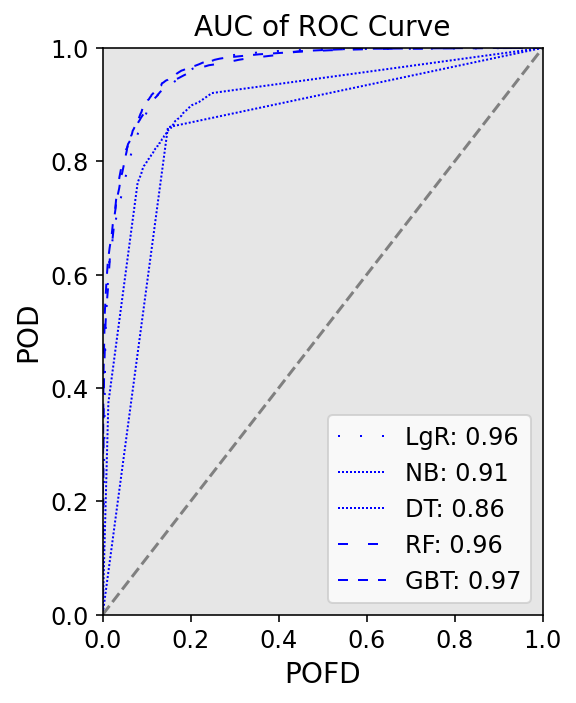

In [27]:
#load contingency_table func
from gewitter_functions import get_points_in_roc_curve,get_area_under_roc_curve

#make figure
fig = plt.figure(figsize=(4.1,5))
#set facecolor to white so you can copy/paste the image somewhere 
fig.set_facecolor('w')

#make list of colors so each method shows up as a different color
colors=['b','b','b','b','b','b']
legend_labels = ['LgR: ','NB: ','DT: ','RF: ','GBT: ','SVM: ']

#this is a fancy way of encoding line styles, dont worry, I do NOT know these, I googled. 
line_styles = [(0, (1, 10)),(0, (1, 1)),(0, (1, 1)),(0, (5, 10)),(0, (5, 5)),(0, (5, 1))]
    
ax = plt.gca()

#loop over all trained models 
for idx,model in enumerate(model_list[:-1]):
    #get predictions 
    yhat_proba = model.predict_proba(X_v)
    
    #lets just focus on the output from class 1 (note, the sum of these two columns should be 1)
    y_preds = yhat_proba[:,1]
    
    #get the roc curve
    pofds, pods = get_points_in_roc_curve(forecast_probabilities=y_preds, observed_labels=y_v, threshold_arg=np.linspace(0,1,100))
    
    #get AUC 
    auc = get_area_under_roc_curve(pofds,pods)
    
    #plot the lines 
    ax.plot(pofds,pods,ls=line_styles[idx],color=colors[idx],label=legend_labels[idx] + str(np.round(auc,2)),lw=1)
    
    print('{} AUC: {}'.format(legend_labels[idx],np.round(auc,2)))
    
#draw legend 
ax.legend()

#set some limits
ax.set_xlim([0,1])
ax.set_ylim([0,1])

#set the no-skill line
ax.plot([0,1],[0,1],'--',color='Grey')

#label things
ax.set_title("AUC of ROC Curve")
ax.set_xlabel('POFD')
ax.set_ylabel('POD')

plt.tight_layout()

<img src="../images/Part1_ROC_Diagram.png"
     alt="PerformancePart1"
     width=350> </img> 
     
As with the performance diagram, it looks like the ML methods perform better on the sub-SEVIR dataset than on the full dataset used in Part 1. 

#### Step 5: Train some regression models! 

We need to rework our training data here a bit. Recall from Part 1 that there are a LOT of 0s in the dataset, meaning there are a lot of non-lightning images. One way around this is to drop the 0s, so that's what we will do first. 

In [28]:
#reload just because sometimes I have trust issues 
df_t = pd.read_csv('/content/WAF_ML_Tutorial_Part2/datasets/sub-sevir-engineered/lowres_features_train.csv')
df_v = pd.read_csv('/content/WAF_ML_Tutorial_Part2/datasets/sub-sevir-engineered/lowres_features_val.csv')

df_t = df_t.where(df_t.label_reg > 0).dropna()
df_v = df_v.where(df_v.label_reg > 0).dropna()

Okay, now that we dropped the 0s we need to remake our X and y vectors. But this time remember that we need the regression label, which is column 37 (not 36). 

In [29]:
X_t = df_t.to_numpy()[:,:36]
y_t = df_t.to_numpy()[:,37]
X_v = df_v.to_numpy()[:,:36]
y_v = df_v.to_numpy()[:,37]

Now let's initialize a new list of models to train:

In [30]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import LinearSVR

#initialize
model_list = [LinearRegression(), DecisionTreeRegressor(), RandomForestRegressor(), GradientBoostingRegressor(), LinearSVR()]

print(model_list)

[LinearRegression(), DecisionTreeRegressor(), RandomForestRegressor(), GradientBoostingRegressor(), LinearSVR()]


Time to train the models!

In [31]:
for model in tqdm.tqdm(model_list):
    model.fit(X_t,y_t)

100%|█████████████████████████████████████████████| 5/5 [01:22<00:00, 16.47s/it]


#### Step 6: Evaluate models

Let's recreate the same regression plots shown in Part 1: the one-to-one diagram and the bar charts with several metrics

n_samples= 4154.0
n_samples= 5143.0
n_samples= 5650.0
n_samples= 5673.0
n_samples= 4555.0


/var/folders/ph/fm42qdjd6vq_mxy6l2ts8sp80000gn/T/ipykernel_78917/4114430687.py:86: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


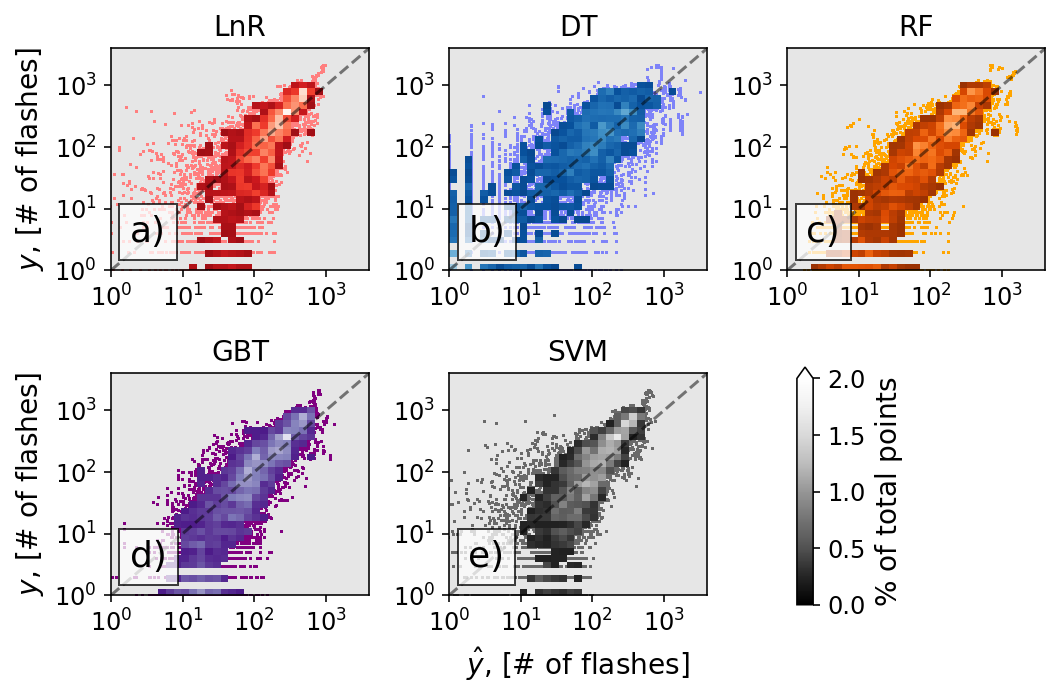

In [34]:
from aux_functions import boxbin,make_colorbar
#make figure with 2 rows and 3 columns with size 7.5" by 5"
fig,axes = plt.subplots(2,3,figsize=(7.5,5))
#set facecolor to white so we can copy paste it if you want to somewhere else
fig.set_facecolor('w')

#the number of bins for the boxbin method 
n = 33
#the bins we want in x and y 
xbins = np.logspace(0,3.5,n)
ybins = np.logspace(0,3.5,n)

#colors i like 
r = [255/255,127/255,127/255]
b = [126/255,131/255,248/255]

#labels
labels= ['LnR','DT','RF','GBT','SVM']
#color list, one for each model 
colors= [r,b,'orange','purple','dimgrey']
#colormaps to match the colors in 'theme'
cmaps=['Reds_r','Blues_r','Oranges_r','Purples_r','Greys_r']

#force ticks to show up where i want them 
locmin = matplotlib.ticker.LogLocator(base=10.0, subs=(0.1,0.2,0.4,0.6,0.8,1,2,4,6,8,10 )) 

#axes is shape [2,3], it is easier to loop if we flatten this, which is what ravel does 
axes = axes.ravel()

#some parameters to make it pretty 
c_scale = 0.575
fs3 = 11
fs4 = 18
props = dict(boxstyle='square', facecolor='White', alpha=0.75)
annotate_list = ['a)','b)','c)','d)','e)',]

#draw a new axis for a new colorbar to go on 
ax_cbar = fig.add_axes([0.75, 0.15, 0.015,0.33])
#draw that colorbar 
cbar = make_colorbar(ax_cbar,0,2,plt.cm.Greys_r)
#label that colorbar 
cbar.set_label('$\%$ of total points')

#loop over axes and draw scatters 
for i,ax in enumerate(axes):
    #we have 1 too many subplots, so turn off the last one [5]
    if i==5:
        ax.axis('off')
        break
    #make axes log-log     
    ax.semilogy()
    ax.semilogx()
    
    #grab model
    model = model_list[i]
    #get predicitions 
    yhat = model.predict(X_v)
    #make scatter plot 
    ax.scatter(yhat,y_v,color=colors[i],s=1,marker='+')
    
    #box and bin up data to show density of points 
    ax,cbar,C = boxbin(yhat,y_v,xbins,ybins,ax=ax,mincnt=10,normed=True,cmap=cmaps[i],vmin=0,vmax=2,cbar=False)
    
    #set some axis limits and ticks 
    ax.set_xlim([1,4000])
    ax.set_xticks([1,10,100,1000])
    ax.set_yticks([1,10,100,1000])
    ax.set_ylim([1,4000])
    
    #add diaganol line 
    ax.plot([1,4000],[1,4000],'--k',alpha=0.5)
    
    #add a subplot label 
    ax.text(0.075, 0.25, annotate_list[i], transform=ax.transAxes,fontsize=fs4,
        verticalalignment='top', bbox=props)
    
    #only label certain axes x-y axis to save space 
    if (i == 0) or (i==3):
        ax.set_ylabel('$y$, [# of flashes]')
    if i==4:
        ax.set_xlabel(r'$\hat{y}$, [# of flashes]')
        
    #label each subplot title as the method used 
    ax.set_title(labels[i])
    
plt.tight_layout()

Comparing to Part 1 again:

<img src="../images/Part1_one2one.png"
     alt="PerformancePart1"
     width=550> </img> 
     
Now, note again that these datasets are much different in size, so just compare the results qualitatively here. 

The results generally look very comparable, and this shows that the traditional ML can still perform well on this lower-resolution dataset.

Let's take a look at the metrics quantitatively now.



In [40]:
from gewitter_functions import get_mae,get_rmse,get_bias,get_r2

#loop over all trained models 
for idx,model in enumerate(model_list):
    #get predictions 
    yhat = model.predict(X_v)
    
    mae = get_mae(y_v,yhat)
    rmse = get_rmse(y_v,yhat)
    bias = get_bias(y_v,yhat)
    r2 = get_r2(y_v,yhat)

    #print them out so we can see them 
    print('Method: {} .. MAE:{} flashes, RMSE:{} flashes, Bias:{} flashes, Rsquared:{}'.format(labels[idx],np.round(mae,2),np.round(rmse,2),np.round(bias,2),np.round(r2,2)))

Method: LnR .. MAE:94.84 flashes, RMSE:153.12 flashes, Bias:35.53 flashes, Rsquared:0.56
Method: DT .. MAE:114.62 flashes, RMSE:216.5 flashes, Bias:16.78 flashes, Rsquared:0.12
Method: RF .. MAE:80.03 flashes, RMSE:153.2 flashes, Bias:20.57 flashes, Rsquared:0.56
Method: GBT .. MAE:79.66 flashes, RMSE:145.51 flashes, Bias:25.61 flashes, Rsquared:0.6
Method: SVM .. MAE:92.58 flashes, RMSE:170.55 flashes, Bias:61.78 flashes, Rsquared:0.46


Numbers like this are useful, but let's make the bar chart again.

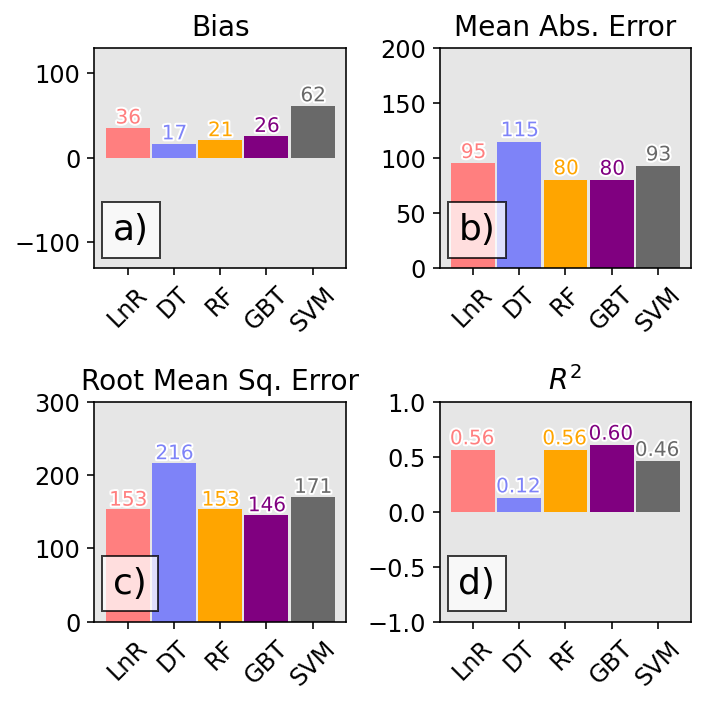

In [41]:
#some annotation helpers
import matplotlib.patheffects as path_effects
pe = [path_effects.withStroke(linewidth=2,
                             foreground="k")]
pe2 = [path_effects.withStroke(linewidth=2,
                             foreground="w")]
#make a 2 row, 2 column figure of size 5" by 5"
fig,axes = plt.subplots(2,2,figsize=(5,5))
#set facecolor to white so we can copy/paste it whereever
fig.set_facecolor('w')

#list of labels for the x-axis 
labels= ['LnR','DT','RF','GBT','SVM']

#loop over all trained models 
for i,model in enumerate(model_list):
    #get predictions 
    yhat = model.predict(X_v)
    mae = get_mae(y_v,yhat)
    rmse = get_rmse(y_v,yhat)
    bias = get_bias(y_v,yhat)
    r2 = get_r2(y_v,yhat)
    
    ############### subplot 0,0: Bias ########################
    ax = axes[0,0]
    #put a bar at position i (from our loop)
    ax.bar(i,bias,width=0.95,color=colors[i])
    #make the annotation so we can see the numerical data on the plot 
    annotate = str(int(np.round(bias))).rjust(3, ' ')
    ax.text(i-0.4,bias+5,annotate,color=colors[i],path_effects=pe2)
    ##########################################################

    ####### subplot 0,1: Mean Absolute Error #################
    ax = axes[0,1]
    #put a bar at position i (from our loop)
    ax.bar(i,mae,width=0.95,color=colors[i])
    #make the annotation so we can see the numerical data on the plot 
    annotate = str(int(np.round(mae))).rjust(3, ' ')
    ax.text(i-0.4,mae+5,annotate,color=colors[i],path_effects=pe2)
    ##########################################################
    
    ####### subplot 1,0: Root Mean Squared Error #############
    ax = axes[1,0]
    ax.bar(i,rmse,width=0.95,color=colors[i])
    annotate = str(int(np.round(rmse))).rjust(3, ' ')
    ax.text(i-0.4,rmse+5,annotate,color=colors[i],path_effects=pe2)
    ##########################################################
    
    ####### subplot 1,1: Rsquared ###########################
    ax = axes[1,1]
    ax.bar(i,r2,width=0.95,color=colors[i])
    annotate = str(np.round(r2,2)).ljust(4, '0')
    ax.text(i-0.5,r2+0.05,annotate,color=colors[i],path_effects=pe2)
    ##########################################################
    

    

#cosmetic things: 
ax = axes[0,0]
ax.xaxis.set_ticks(np.arange(0,5))
ax.xaxis.set_ticklabels(labels,rotation=45)
ax.set_ylim([-130,130])
ax.set_title("Bias")
ax.text(0.075, 0.25, annotate_list[0], transform=ax.transAxes,fontsize=fs4,
verticalalignment='top', bbox=props)

ax = axes[0,1]
ax.set_ylim([0,200])
ax.xaxis.set_ticks(np.arange(0,5))
ax.xaxis.set_ticklabels(labels,rotation=45)
ax.set_title("Mean Abs. Error")
ax.text(0.075, 0.25, annotate_list[1], transform=ax.transAxes,fontsize=fs4,
verticalalignment='top', bbox=props)

ax = axes[1,0]
ax.set_ylim([0,300])
ax.xaxis.set_ticks(np.arange(0,5))
ax.xaxis.set_ticklabels(labels,rotation=45)
ax.set_title("Root Mean Sq. Error")
ax.text(0.075, 0.25, annotate_list[2], transform=ax.transAxes,fontsize=fs4,
verticalalignment='top', bbox=props)

ax = axes[1,1]
ax.set_ylim([-1,1])
ax.xaxis.set_ticks(np.arange(0,5))
ax.xaxis.set_ticklabels(labels,rotation=45)
ax.set_title("$R^{2}$")
ax.text(0.075, 0.25, annotate_list[3], transform=ax.transAxes,fontsize=fs4,
verticalalignment='top', bbox=props)
    
plt.tight_layout()

Comparing to Part 1 again:

<img src="../images/Part1_barcharts.png"
     alt="PerformancePart1"
     width=350> </img> 
     
Quantitatively, the errors are slightly worse than in Part 1, but they are still pretty close.

#### A Note about 'why'

Why did we have you go through the pain of re-training these models? This is because the low-resolution dataset doesn't have the same amount of information content as the orignial full-resolution dataset. So if we were to just skip over this exercise, than the comparison of the neural network results would not be fair, and it would be hard to tell which methods perform better than others (or worse). 

Now that we have a baseline to compare to, the next notebook we will dive into ```tensorflow```, which is the ```sklearn``` for all things neural networks. 